In [ ]:
import time

import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad, random, nn
from jax.example_libraries import optimizers

import matplotlib.pyplot as plt

key = random.PRNGKey(seed=0)

In [ ]:
conditions_data_num = 500
collocation_points_data_num = 5000

key = random.PRNGKey(seed=0)

rho = 1
mu = 1
u_in = 1
D = 1
L = 2

# domain data
x_key, y_key = random.split(key, 2)
collocation_points_x = random.uniform(
    key=x_key, 
    minval=-1, maxval=1, 
    shape=(collocation_points_data_num, 1)
)
collocation_points_y = random.uniform(
    key=y_key, 
    minval=-0.5, maxval=0.5, 
    shape=(collocation_points_data_num, 1)
)
collocation_points = jnp.hstack((collocation_points_x, collocation_points_y))

# boundary data
data_num_each_boundary = int(conditions_data_num / 4)
x_key, y_key = random.split(key, 2)
random_x = random.uniform(
    key=x_key, 
    minval=-1.0, maxval=1.0, 
    shape=(data_num_each_boundary, 2)
)
random_y = random.uniform(
    key=y_key, 
    minval=-0.5, maxval=0.5, 
    shape=(data_num_each_boundary, 2)
)

upper = jnp.hstack((jnp.expand_dims(random_x[:, 0], axis=1), jnp.ones([data_num_each_boundary, 1]) * 0.5))
lower = jnp.hstack((jnp.expand_dims(random_x[:, 1], axis=1), jnp.ones([data_num_each_boundary, 1]) * -0.5))
left = jnp.hstack((jnp.ones([data_num_each_boundary, 1]) * -1, jnp.expand_dims(random_y[:, 0], axis=1)))
right = jnp.hstack((jnp.ones([data_num_each_boundary, 1]) * 1, jnp.expand_dims(random_y[:, 1], axis=1)))

bc_collocation_points = jnp.vstack((upper, lower, left, right))
bc_x, bc_y = bc_collocation_points[:, 0], bc_collocation_points[:, 1]

x_1 = jnp.ones([conditions_data_num, 1])
y_d2 = jnp.ones([conditions_data_num, 1]) * D / 2

# boundary conditions
bc_0 = jnp.zeros([conditions_data_num, 1])
bc_1 = jnp.zeros([conditions_data_num, 1])
bc_2 = jnp.ones([conditions_data_num, 1])
bc_3 = jnp.zeros([conditions_data_num, 1])
bc_4 = jnp.zeros([conditions_data_num, 1])
bc_5 = jnp.zeros([conditions_data_num, 1])

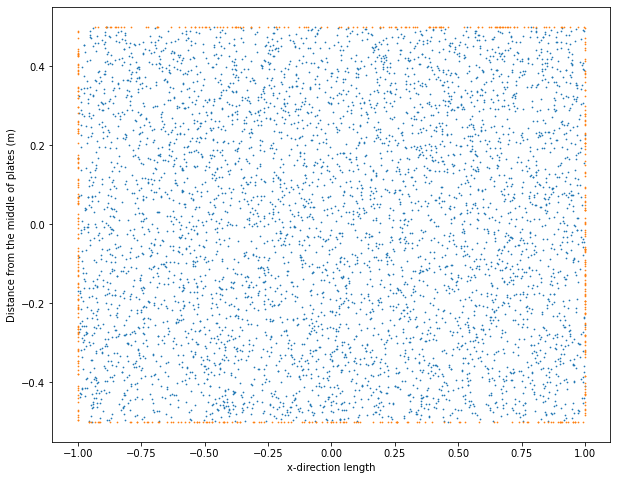

In [ ]:
plt.figure(figsize = (10,8))
plt.scatter(collocation_points[:,0], collocation_points[:,1], s = 0.5)
plt.scatter(bc_collocation_points[:,0], bc_collocation_points[:,1], s = 0.5)
plt.xlabel('x-direction length')
plt.ylabel('Distance from the middle of plates (m)')
plt.show()

In [ ]:
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key):
        w_key, b_key = random.split(key)
        lb, ub = -(1 / jnp.sqrt(n)), (1 / jnp.sqrt(m))
        return lb + (ub-lb) *  random.uniform(w_key, (m, n)), random.uniform(b_key, (n,))

    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [2] + [64]*5 + [3]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

In [ ]:
def fwd(params, x, y):
    """ Compute the forward pass for each example individually """
    in_array = jnp.hstack((x, y))
    activations = in_array

    for w, b in params[:-1]:
        activations = nn.tanh(jnp.dot(activations, w) + b)

    # Perform final trafo to logits
    final_w, final_b = params[-1]
    output = jnp.dot(activations, final_w) + final_b
    return output

# Make a batched version of the `predict` function
fwd = vmap(fwd, in_axes=(None, 0, 0), out_axes=0)

In [ ]:
def pde_loss(x, y, ufunc, vfunc, ufunc_x, ufunc_y, vfunc_x, vfunc_y, pfunc_x, pfunc_y, ufunc_xx, ufunc_yy, vfunc_xx, vfunc_yy):
    u = ufunc(x, y)
    v = vfunc(x, y)

    du_x = ufunc_x(x, y)
    du_y = ufunc_y(x, y)
    dv_x = vfunc_x(x, y)
    dv_y = vfunc_y(x, y)
    dp_x = pfunc_x(x, y)
    dp_y = pfunc_y(x, y)

    du_xx = ufunc_xx(x, y)
    du_yy = ufunc_yy(x, y)
    dv_xx = vfunc_xx(x, y)
    dv_yy = vfunc_yy(x, y)

    pde_u = u*du_x + v*du_y + 1/rho * dp_x - (mu/rho)*(du_xx + du_yy)
    pde_v = u*dv_x + v*dv_y + 1/rho * dp_y - (mu/rho)*(dv_xx + dv_yy)
    pde_cont = du_x + dv_y

    return pde_u, pde_v, pde_cont



def loss_fun(params, colloc):
    x_c = colloc[:,[0]]
    y_c = colloc[:,[1]]

    loss = 0
    outputs = lambda x, y: fwd(params, x, y)

    ufunc = lambda x, y: outputs(x, y)[:, 0]
    ufunc_x = lambda x, y: grad(lambda a, b:jnp.sum(ufunc(a, b)), argnums=0)(x, y)
    ufunc_y = lambda x, y: grad(lambda a, b:jnp.sum(ufunc(a, b)), argnums=1)(x, y)
    ufunc_xx = lambda x, y: grad(lambda a, b:jnp.sum(ufunc_x(a, b)), argnums=0)(x, y)
    ufunc_yy = lambda x, y: grad(lambda a, b:jnp.sum(ufunc_y(a, b)), argnums=1)(x, y)

    vfunc = lambda x, y: outputs(x, y)[:, 1]
    vfunc_x = lambda x, y: grad(lambda a, b:jnp.sum(vfunc(a, b)), argnums=0)(x, y)
    vfunc_y = lambda x, y: grad(lambda a, b:jnp.sum(vfunc(a, b)), argnums=1)(x, y)
    vfunc_xx = lambda x, y: grad(lambda a, b:jnp.sum(vfunc_x(a, b)), argnums=0)(x, y)
    vfunc_yy = lambda x, y: grad(lambda a, b:jnp.sum(vfunc_y(a, b)), argnums=1)(x, y)

    pfunc = lambda x, y: outputs(x, y)[:, 2]
    pfunc_x = lambda x, y: grad(lambda a, b:jnp.sum(pfunc(a, b)), argnums=0)(x, y)
    pfunc_y = lambda x, y: grad(lambda a, b:jnp.sum(pfunc(a, b)), argnums=1)(x, y)

    # governing equation
    pde_u, pde_v, pde_cont = pde_loss(x_c, y_c, ufunc, vfunc, ufunc_x, ufunc_y, vfunc_x, vfunc_y, pfunc_x, pfunc_y, ufunc_xx, ufunc_yy, vfunc_xx, vfunc_yy)
    loss += jnp.mean(jnp.square(pde_u))
    loss += jnp.mean(jnp.square(pde_v))
    loss += jnp.mean(jnp.square(pde_cont))

    # boundary conditions
    loss += jnp.mean(jnp.square(ufunc(bc_x, -y_d2) - bc_0))
    loss += jnp.mean(jnp.square(ufunc(bc_x, y_d2) - bc_0))

    loss += jnp.mean(jnp.square(vfunc(bc_x, -y_d2) - bc_1))
    loss += jnp.mean(jnp.square(vfunc(bc_x, y_d2) - bc_1))

    loss += jnp.mean(jnp.square(ufunc(-x_1, bc_y) - bc_2))
    loss += jnp.mean(jnp.square(vfunc(-x_1, bc_y) - bc_3))
    loss += jnp.mean(jnp.square(vfunc(x_1, bc_y) - bc_4))
    loss += jnp.mean(jnp.square(pfunc(x_1, bc_y) - bc_5))

    return loss

In [ ]:
# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

@jit
def update(params, train_x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss_fun)(params, train_x)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state

In [ ]:
epochs = 10_000

train_loss = []
for epoch in range(epochs):
    params, opt_state = update(params, collocation_points, opt_state)

    # print loss and epoch info
    if epoch % 1000 == 999:
        loss = loss_fun(params, collocation_points)
        train_loss.append(loss)
        print(f'Epoch={epoch}\tloss={loss:.3e}')

Epoch=999	loss=4.534e-01
Epoch=1999	loss=4.438e-01
Epoch=2999	loss=4.211e-01
Epoch=3999	loss=3.815e-01
Epoch=4999	loss=3.561e-01
Epoch=5999	loss=3.369e-01
Epoch=6999	loss=3.164e-01
Epoch=7999	loss=3.031e-01
Epoch=8999	loss=2.971e-01
Epoch=9999	loss=2.944e-01


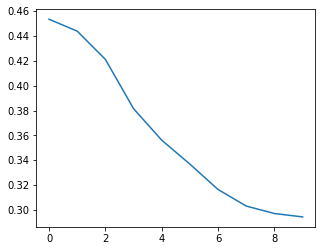

In [ ]:
plt.figure(figsize = (5,4))
plt.plot(train_loss)
plt.show()

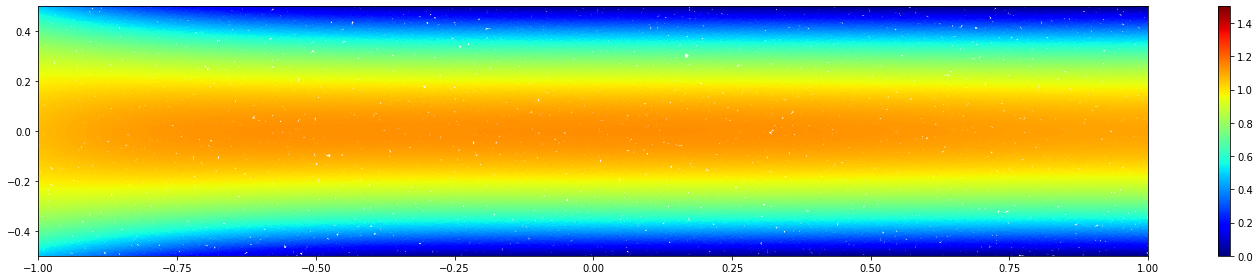

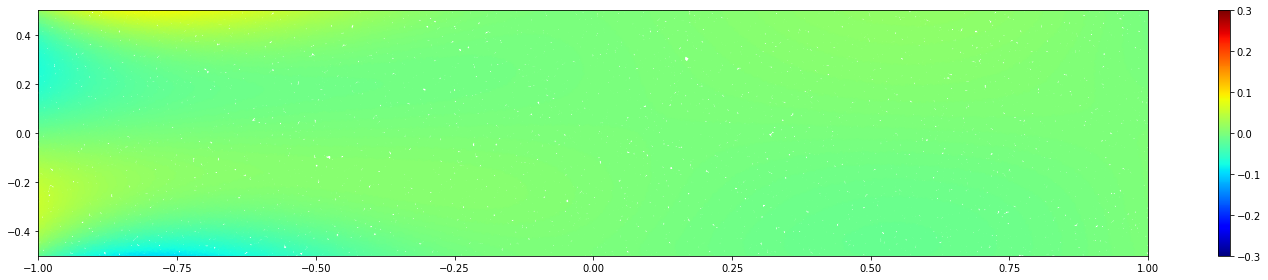

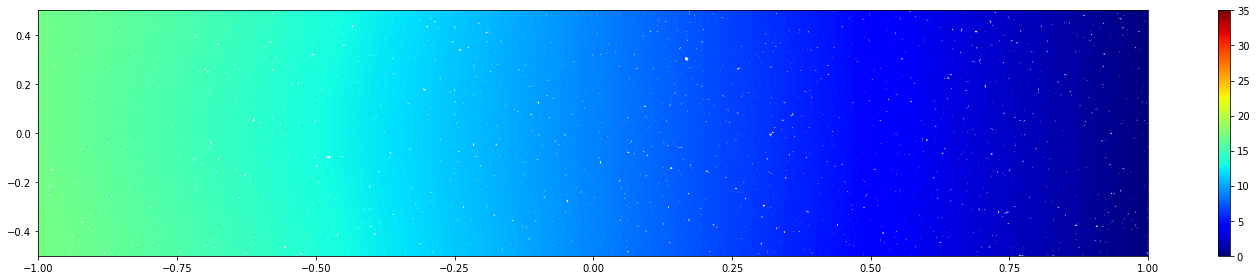

In [ ]:
samples = random.uniform(
    key=key, 
    minval=-1, maxval=1, 
    shape=(500000, 2)
)
result = fwd(params, samples[:, 0], samples[:, 1])

color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize = (20, 4))
    plt.scatter(samples[:, 0],
                samples[:, 1],
                c = result[:, idx],
                cmap = 'jet',
                s = 3)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.show()
